In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
import os
import sys
import glob
import time
import warnings
from datetime import datetime
from datetime import date
print("Last updated on ", time.asctime())

Last updated on  Sun Mar 29 18:12:30 2020


In [39]:
import numpy as np
import pandas as pd
import matplotlib

In [40]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [41]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d
from dataclasses import dataclass, field

In [44]:
from scipy.stats import lognorm

In [42]:
import invisible_cities.core .fit_functions  as     fitf

In [229]:
import c19.c19stats as sts 

In [230]:
import c19.plotting as cplt

In [259]:
import c19.io as cio

In [302]:
from c19.types import Country

#### Theoretical background

- the case fatality ratio (CFR) is the conditional probability of death given infection
- The CFR in general is vaguely defined as the ratio of deaths to cases, whose denominator should ideally be the total number of infections, but is frequently taken to be only the diagnosed cases due to the impossibility of counting all infected individuals. Because in the early phase of an outbreak information is often limited to confirmed cases, we concentrate on confirmed cases only, and refer to the CFR as the confirmed CFR (cCFR) for clarity.
- A much-used crude estimate of the cCFR, i.e. the ratio of the cumulative number of deaths to cases at calendar time t, tends to yield a biased (and mostly underestimated) cCFR due to the time-delay from onset to death.
- The cCFR is interpreted as the conditional probability of death given confirmed diagnosis.

- In the following, the notation used to represent the three different statistical measurements of cCFR is: 
    - (i) bt, which is a crude, biased estimate of the cCFR calculated at time t; 
    - (ii) $\pi$, which is an unbiased cCFR to be estimated in the present study, and is the unknown parameter that governed the outbreaks; and 
    - (iii) pt, a random variable, which yields an estimator of p (see below) and is regarded as the realized value in one particular outbreak. 
    - (iv) ct (i.e. the number of new confirmed cases on day t)

- First, bt, a crude and biased estimate of cCFR, calculated at time t, is given by the ratio of the cumulative number of deaths Dt to the cumulative number of confirmed cases Ct:

$$ b_t = \frac{D_t}{C_t} $$

- Ct is the cumulative number of confirmed cases up to time t:

$$ C_t = \sum_{t=0}^t c_i $$

- Dt is the cumulative number of deaths up to time t:

$$ D_t = p_t \sum_{i=0}^t \sum_{j=0}^\infty c_{ij} f_j$$

- pt is the realized proportion of confirmed cases to die from the infection.
- fs is the conditional probability density function of the time from onset to death, given death.

Then

$$ p_t = \frac{b_t}{u_t} $$

And:

$$ u_t = \frac{\sum_{i=0}^t \sum_{j=0}^\infty c_{ij} f_j}{C_i} $$

- The cumulative number of cases Ct is regarded as the total population size. Of these, only a proportion ut has been at risk for dying by time t, whereas the outcome for the remaining proportion 1 - ut is still unobserved. Among the $u_t \cdot C_t$ cases that have been at risk, Dt have died and 
$u_t C_t – D_t$ have survived the infection. This is a sample from a binomial distribution with sample size utCt and probability $\pi$:

$$ Pr (X= Dt) = \binom{u_t C_t}{D_t} \pi^{D_t} (1 - \pi)^{u_tC_t - D_t}$$

And thus we can obtain a Likelihood function to obtain the maximum likelihood estimate of pt.

$$ L(p_t; C_t, D_t, u_t) = \binom{u_t C_t}{D_t} p_t^{D_t} (1 - p_t)^{u_tC_t - D_t}$$

#### Approximations for the exponential growth phase

- Whereas we discussed incidence in discrete time in the main text, here we use continuous time arguments for mathematical convenience; incidence and factor of underestimation at time t are denoted by c(t) and u(t), respectively. Although the most precise estimates of the unbiased cCFR are obtained by calculation of u(t) by use of equation (6) (so that pt can be estimated), we have also derived a simple approximation for u(t) in the early (exponential) growth phase of an epidemic. If we observe an exponential increase of onsets during the early stage of an epidemic with growth rate r, the expectation of incidence E(c(t)) can be written as

$$ E(c(t)) = c_0 \exp{(r t)} $$

Then

$$ u = \frac{\int_0^t \exp{(r \tau)} \int_0^\infty \exp{(-rs)} f(s) ds d\tau}{\int_0^t \exp{(r \tau)} d \tau}$$

- when f(s) is the density of an exponential distribution with mean T, we have 

$$u = M(-r) = \frac{1}{1 + r T} $$ 


# Lognormal distribution

- Definition. If X has a lognormal distribution, then Z=log(X) has a normal distribution. (Here, as usually, log is taken to be the natural logarithm.)

- Parameters. The normal variable Z is best characterized by mean $\mu$ and variance $\sigma^2$ or standard deviation $\sigma$.
- If you transform to the lognormal X by X=exp(Z), then
    - $\mu^* =\exp(\mu)$ is the median and
    - $\sigma^* =\exp(\sigma)$ is what we call the multiplicative standard deviation. 


- The mean (expectation) of X is
 $$ E(X) = \exp( \mu + \sigma^2/2 ) $$
- The variance,
 $$ var(X) = \exp( \sigma^2 + 2 \mu) ( \exp(\sigma^2)-1 )$$
- The median,
$$ med(X) = \exp(\mu) = \mu^* $$
- The ratio mean/median  is:
$$ mean/median = \exp(\sigma^2/2)$$
- Thus:
$$ \sigma = \sqrt{2 * (log(mean) - log(median))}$$

# 

## Fit data

In [77]:
zmeanHDT          = 13           # mean delay of log-normal fit
zsdHDT            = 12.7         # SD
zmedianHDT        = 9.1
muHDT             = np.log(zmedianHDT)
sigmaHDT          = np.sqrt(2*(np.log(zmeanHDT) - np.log(zmedianHDT)))
cCFRBaseline      =  1.38
cCFREstimateRange = (1.23, 1.53)
print(f' zmeanHDT ={zmeanHDT}, zsdHDT = {zsdHDT}, zmedianHDT = {zmedianHDT}, muHDT = {muHDT:.2f}, sigmaHDT={sigmaHDT:.2f}')

 zmeanHDT =13, zsdHDT = 12.7, zmedianHDT = 9.1, muHDT = 2.21, sigmaHDT=0.84


#  Adjusting for outcome delay in CFR estimates

During an outbreak, the naive CFR (nCFR), i.e. the ratio of reported deaths date to reported cases to date, will underestimate the true CFR because the outcome (recovery or death) is not known for all cases. We can therefore estimate the true denominator for the CFR (i.e. the number of cases with known outcomes) by accounting for the delay from confirmation-to-death.

We assumed the delay from confirmation-to-death followed the same distribution as estimated hospitalisation-to-death, based on data from the COVID-19 outbreak in Wuhan, China, between the 17th December 2019 and the 22th January 2020, accounting right-censoring in the data as a result of as-yet-unknown disease outcomes (Figure 1, panels A and B in [Linton NM, Kobayashi T, Yang Y et al. Incubation period and other epidemiological characteristics of 2019 novel coronavirus infections with right truncation: A statistical analysis of publicly available case data. Journal of Clinical Medicine 2020;9:538.]). The distribution used is a Lognormal fit, has a mean delay of 13 days and a standard deviation of 12.7 days.

To correct the CFR, we use the case and death incidence data to estimate the number of cases with known outcomes:

$$
u_t = \frac{\sum_{i=0}^t \sum_{i=0}^\infty c_{i−j}f_j}{\sum_{i=0}^t c_i} 
$$

where $u_t$
represents the underestimation of the known outcomes and is used to scale the value of the cumulative number of cases in the denominator in the calculation of the cCFR, $c_t$ is the daily case incidence at time, t and $f_t$ is the proportion of cases with delay of t between confirmation and death.

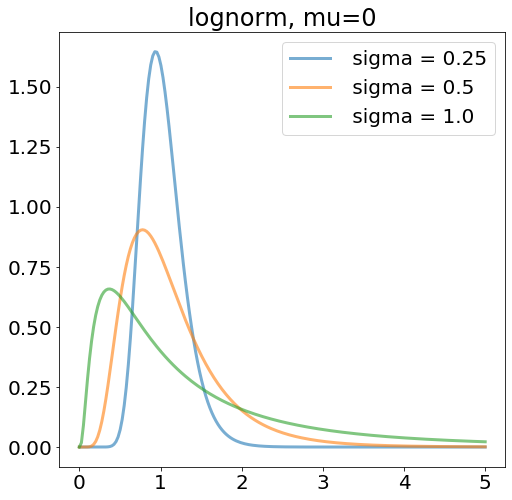

In [233]:
cplt.plot_lognorm_pdf(mu=0, sigmas=(0.25, 0.5, 1.), figsize=(8,8))

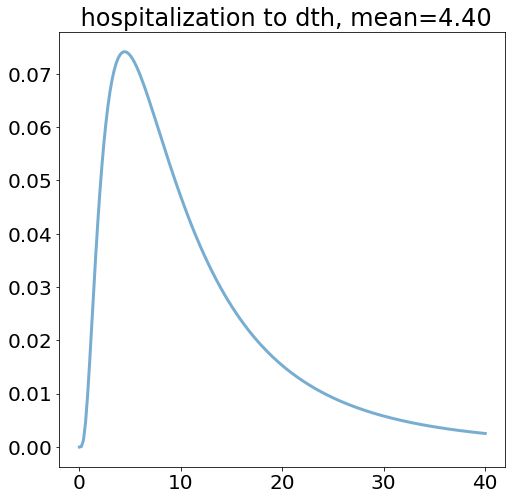

In [234]:
cplt.plot_hospitalisation_to_dth()

In [322]:
df = cio.read_ecdc()

writing file ../data/COVID-19-geographic-disbtribution-worldwide-2020-03-30.xlsx


In [323]:
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,2020-03-29,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0
1,2020-03-28,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0
2,2020-03-27,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0
3,2020-03-26,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0
4,2020-03-25,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0


In [324]:
country = Country(name='Spain', code='ES')
country

Country(name='Spain', code='ES')

In [325]:
dfs = cio.ecdc_select_country(df, country=country.code, thr=2)
dfs

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
6420,2020-03-29,29,3,2020,8189,832,Spain,ES,ESP,46723749.0
6421,2020-03-28,28,3,2020,7871,769,Spain,ES,ESP,46723749.0
6422,2020-03-27,27,3,2020,8578,655,Spain,ES,ESP,46723749.0
6423,2020-03-26,26,3,2020,7937,738,Spain,ES,ESP,46723749.0
6424,2020-03-25,25,3,2020,6584,514,Spain,ES,ESP,46723749.0
6425,2020-03-24,24,3,2020,4517,462,Spain,ES,ESP,46723749.0
6426,2020-03-23,23,3,2020,3646,394,Spain,ES,ESP,46723749.0
6427,2020-03-22,22,3,2020,4946,324,Spain,ES,ESP,46723749.0
6428,2020-03-21,21,3,2020,2833,235,Spain,ES,ESP,46723749.0
6429,2020-03-20,20,3,2020,3431,169,Spain,ES,ESP,46723749.0


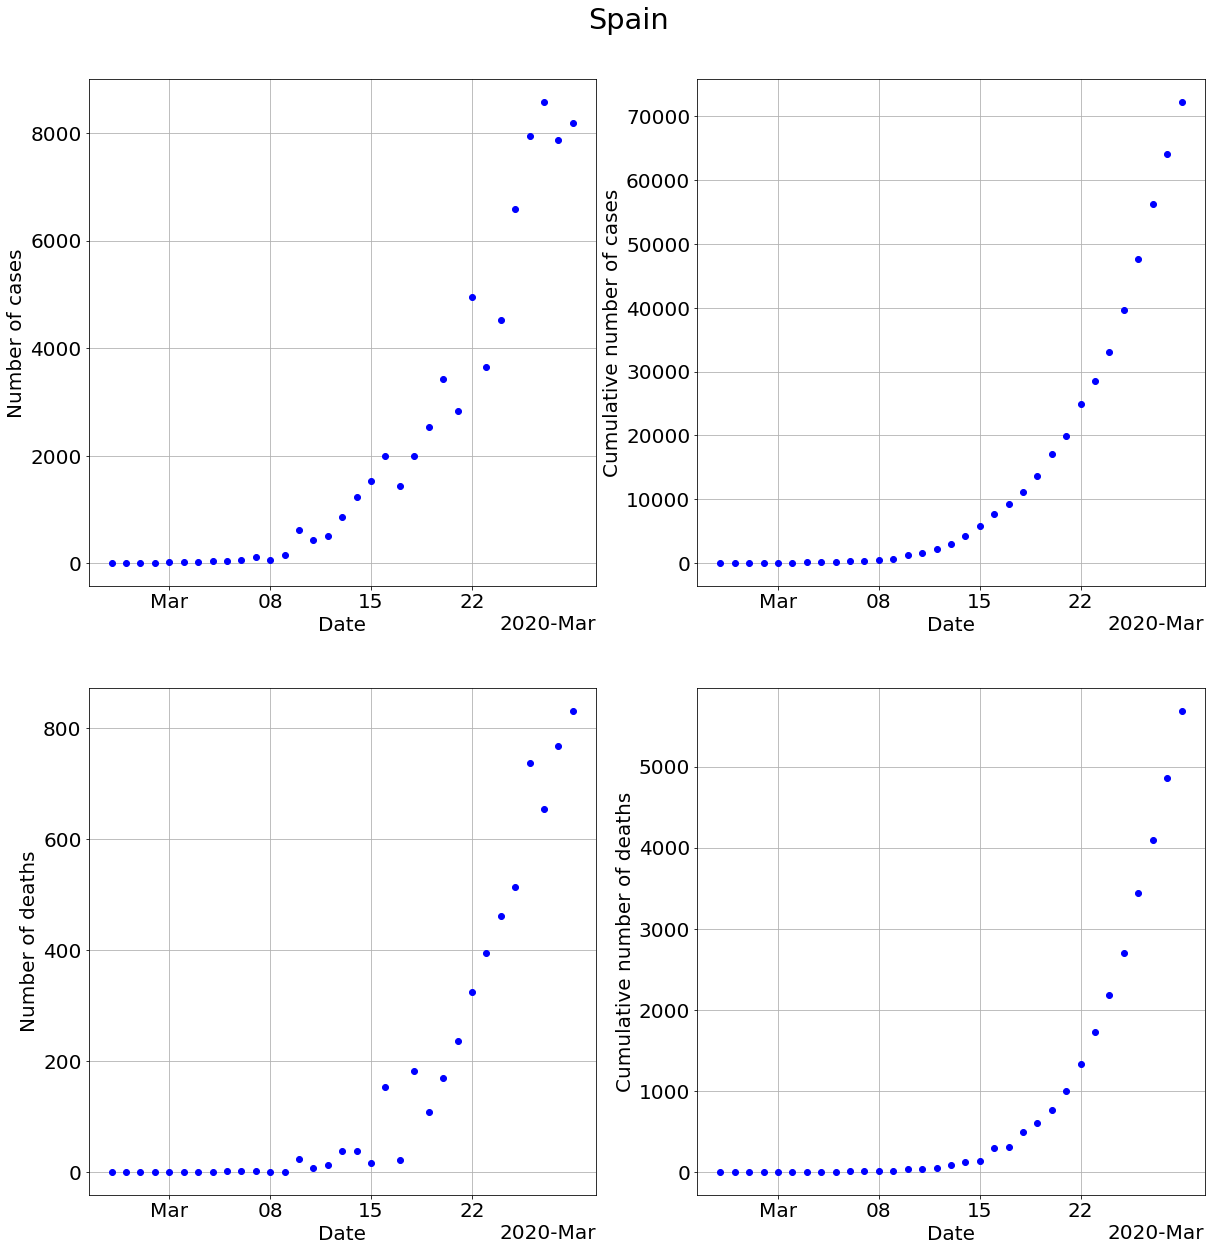

 Total cases   confirmed =72245
 Total deaths  confirmed =5690


In [326]:
cplt.plot_cases_and_deaths(dfs, country= country.name, figsize=(20,20), log=False)

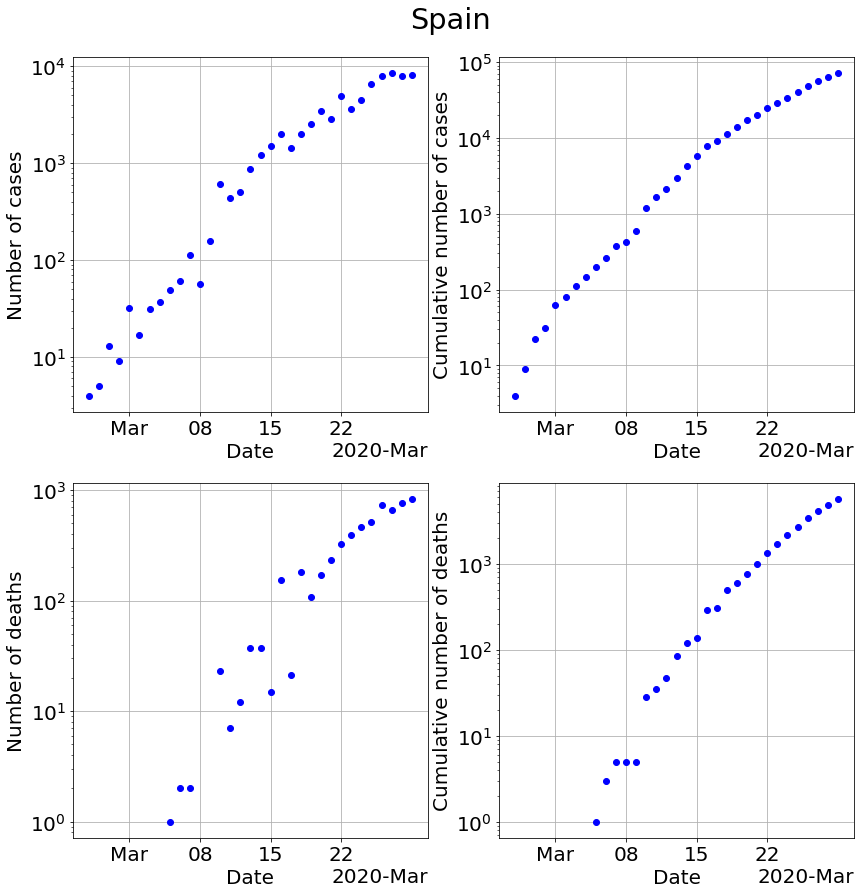

 Total cases   confirmed =72245
 Total deaths  confirmed =5690


In [327]:
cplt.plot_cases_and_deaths(dfs, country= country.name, figsize=(14,14), log=True)

In [328]:
underreporting_estimate, total_cases = sts.total_cases(dfs, cCFRBaseline = 1.38) 
print(f' Country ={country.name}')
print(f' under reporting = {underreporting_estimate:.2e}')
print(f' total cases = {total_cases:.2f}')

 Country =Spain
 under reporting = 1.38e-01
 total cases = 525366.88


In [329]:
dfi = cio.ecdc_select_country(df, country='IT', thr=2)
dfi

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
3648,2020-03-29,29,3,2020,5974,887,Italy,IT,ITA,60431283.0
3649,2020-03-28,28,3,2020,5959,971,Italy,IT,ITA,60431283.0
3650,2020-03-27,27,3,2020,6153,660,Italy,IT,ITA,60431283.0
3651,2020-03-26,26,3,2020,5210,685,Italy,IT,ITA,60431283.0
3652,2020-03-25,25,3,2020,5249,743,Italy,IT,ITA,60431283.0
3653,2020-03-24,24,3,2020,4789,601,Italy,IT,ITA,60431283.0
3654,2020-03-23,23,3,2020,5560,649,Italy,IT,ITA,60431283.0
3655,2020-03-22,22,3,2020,6557,795,Italy,IT,ITA,60431283.0
3656,2020-03-21,21,3,2020,5986,625,Italy,IT,ITA,60431283.0
3657,2020-03-20,20,3,2020,5322,429,Italy,IT,ITA,60431283.0


In [313]:
italy = Country(name='Italy', code='IT')

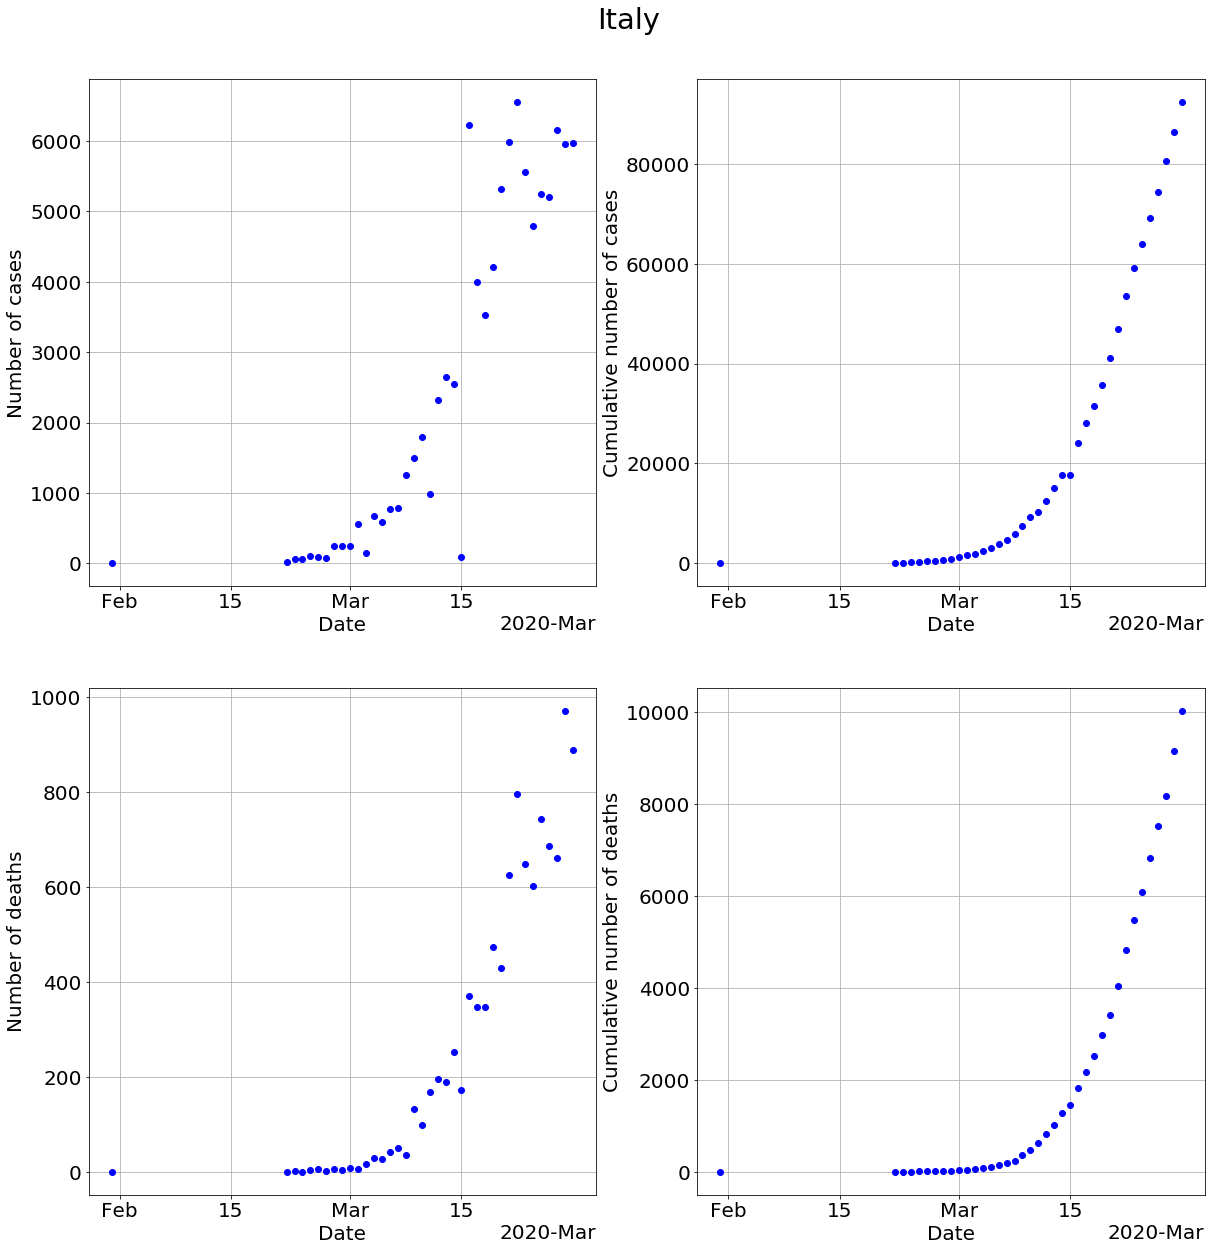

 Total cases   confirmed =92472
 Total deaths  confirmed =10023


In [315]:
cplt.plot_cases_and_deaths(dfi, country= italy.name, figsize=(20,20), log=False)

In [316]:
underreporting_estimate, total_cases = sts.total_cases(dfi, cCFRBaseline = 1.38) 
print(f' Country ={italy.name}')
print(f' under reporting = {underreporting_estimate:.2e}')
print(f' total cases = {total_cases:.2f}')

 Country =Italy
 under reporting = 1.06e-01
 total cases = 872570.25


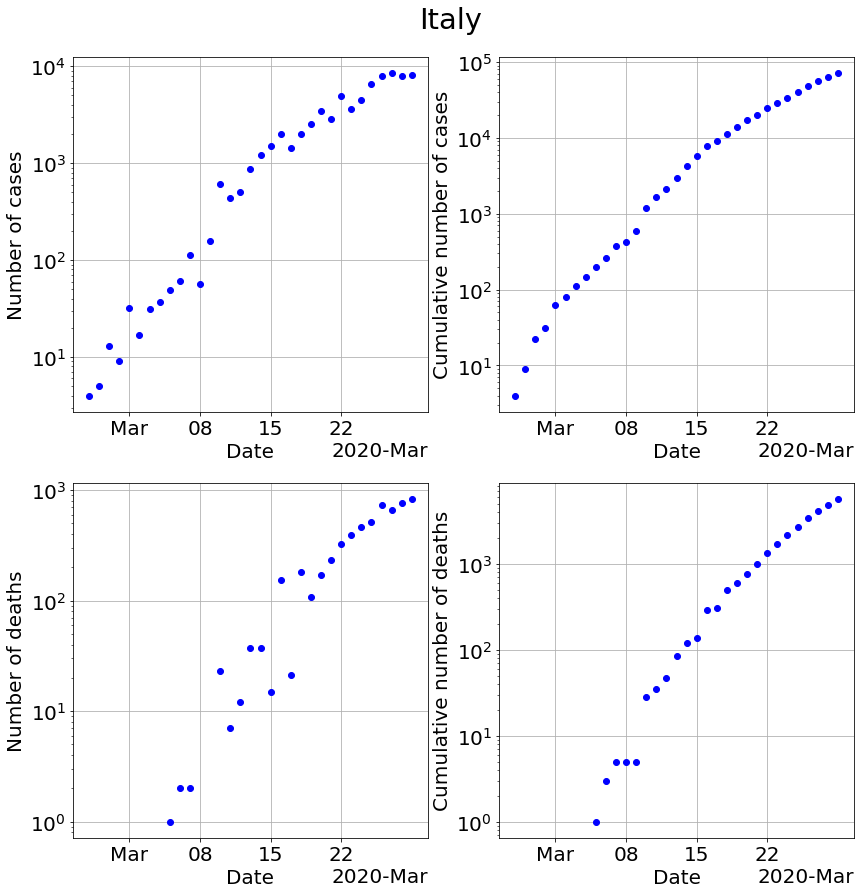

 Total cases   confirmed =72245
 Total deaths  confirmed =5690


In [317]:
cplt.plot_cases_and_deaths(dfs, country= italy.name, figsize=(14,14), log=True)

In [318]:
dfus = cio.ecdc_select_country(df, country='US', thr=2)
dfus

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
7269,2020-03-29,29,3,2020,19979,484,United_States_of_America,US,USA,327167434.0
7270,2020-03-28,28,3,2020,18695,411,United_States_of_America,US,USA,327167434.0
7271,2020-03-27,27,3,2020,16797,246,United_States_of_America,US,USA,327167434.0
7272,2020-03-26,26,3,2020,13963,249,United_States_of_America,US,USA,327167434.0
7273,2020-03-25,25,3,2020,8789,211,United_States_of_America,US,USA,327167434.0
7274,2020-03-24,24,3,2020,11236,119,United_States_of_America,US,USA,327167434.0
7275,2020-03-23,23,3,2020,8459,131,United_States_of_America,US,USA,327167434.0
7276,2020-03-22,22,3,2020,7123,80,United_States_of_America,US,USA,327167434.0
7277,2020-03-21,21,3,2020,5374,110,United_States_of_America,US,USA,327167434.0
7278,2020-03-20,20,3,2020,4835,0,United_States_of_America,US,USA,327167434.0


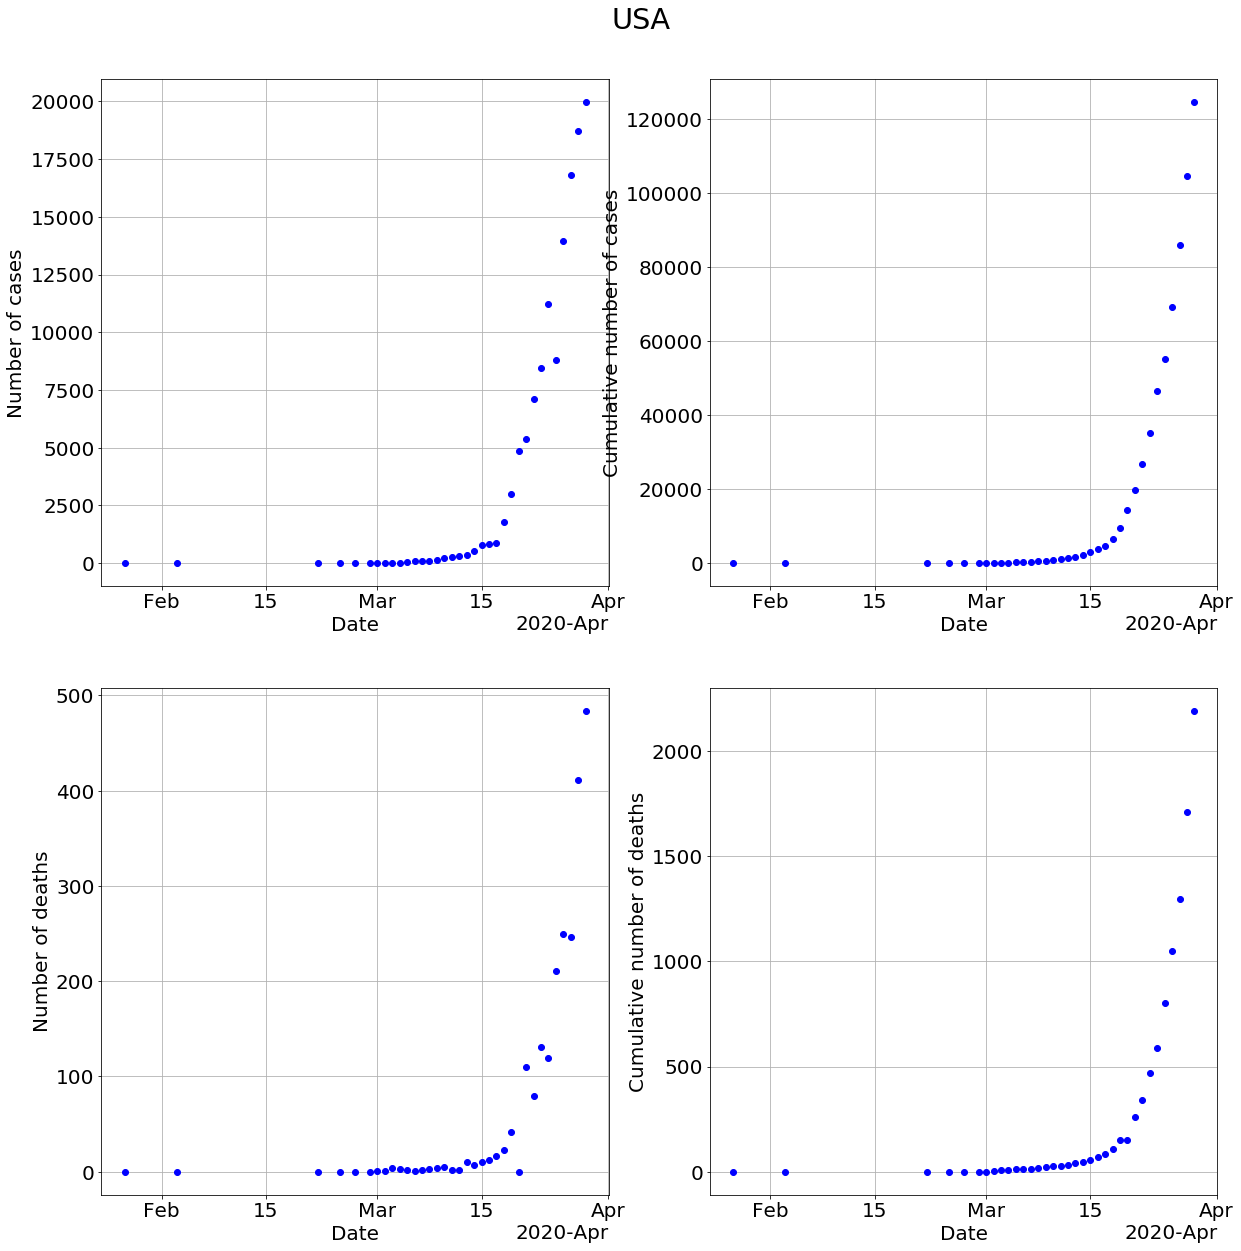

 Total cases   confirmed =124654
 Total deaths  confirmed =2191


In [320]:
cplt.plot_cases_and_deaths(dfus, country= 'USA', figsize=(20,20), log=False)

In [321]:
underreporting_estimate, total_cases = sts.total_cases(dfus, cCFRBaseline = 1.38) 
print(f' Country =USA')
print(f' under reporting = {underreporting_estimate:.2e}')
print(f' total cases = {total_cases:.2f}')

 Country =USA
 under reporting = 6.04e-01
 total cases = 206511.51


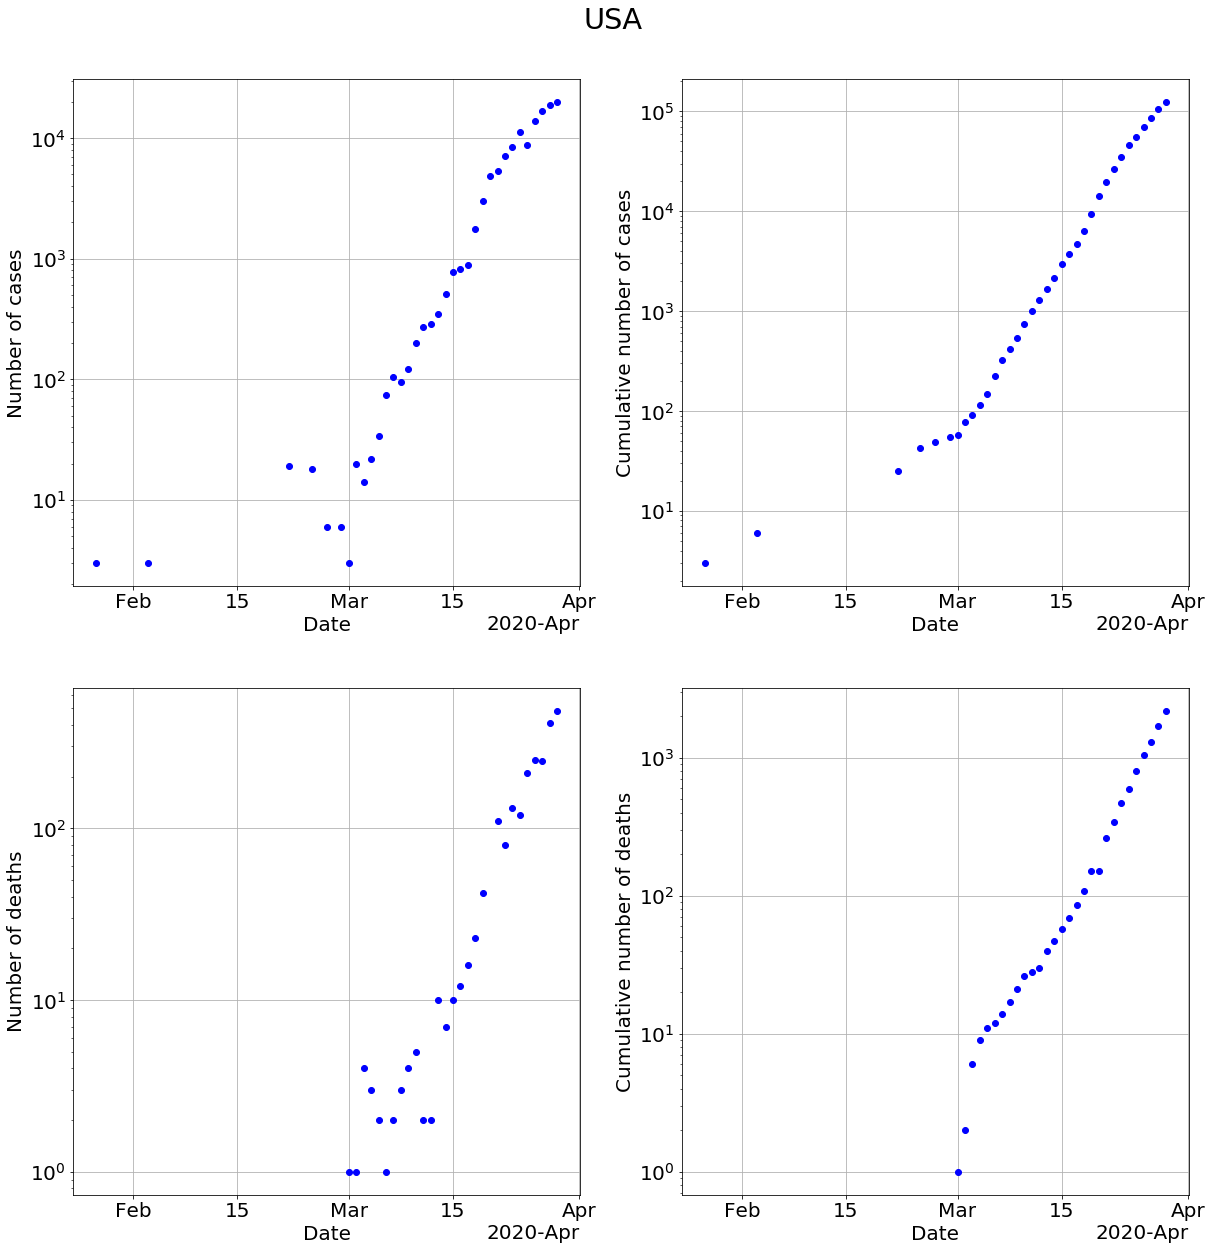

 Total cases   confirmed =124654
 Total deaths  confirmed =2191


In [330]:
cplt.plot_cases_and_deaths(dfus, country= 'USA', figsize=(20,20), log=True)

In [332]:
dfcn = cio.ecdc_select_country(df, country='CN', thr=2)
dfcn

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
1443,2020-03-29,29,3,2020,129,5,China,CN,CHN,1.392730e+09
1444,2020-03-28,28,3,2020,134,3,China,CN,CHN,1.392730e+09
1445,2020-03-27,27,3,2020,111,5,China,CN,CHN,1.392730e+09
1446,2020-03-26,26,3,2020,121,6,China,CN,CHN,1.392730e+09
1447,2020-03-25,25,3,2020,99,4,China,CN,CHN,1.392730e+09
1448,2020-03-24,24,3,2020,99,7,China,CN,CHN,1.392730e+09
1449,2020-03-23,23,3,2020,150,9,China,CN,CHN,1.392730e+09
1450,2020-03-22,22,3,2020,83,6,China,CN,CHN,1.392730e+09
1451,2020-03-21,21,3,2020,79,7,China,CN,CHN,1.392730e+09
1452,2020-03-20,20,3,2020,99,4,China,CN,CHN,1.392730e+09


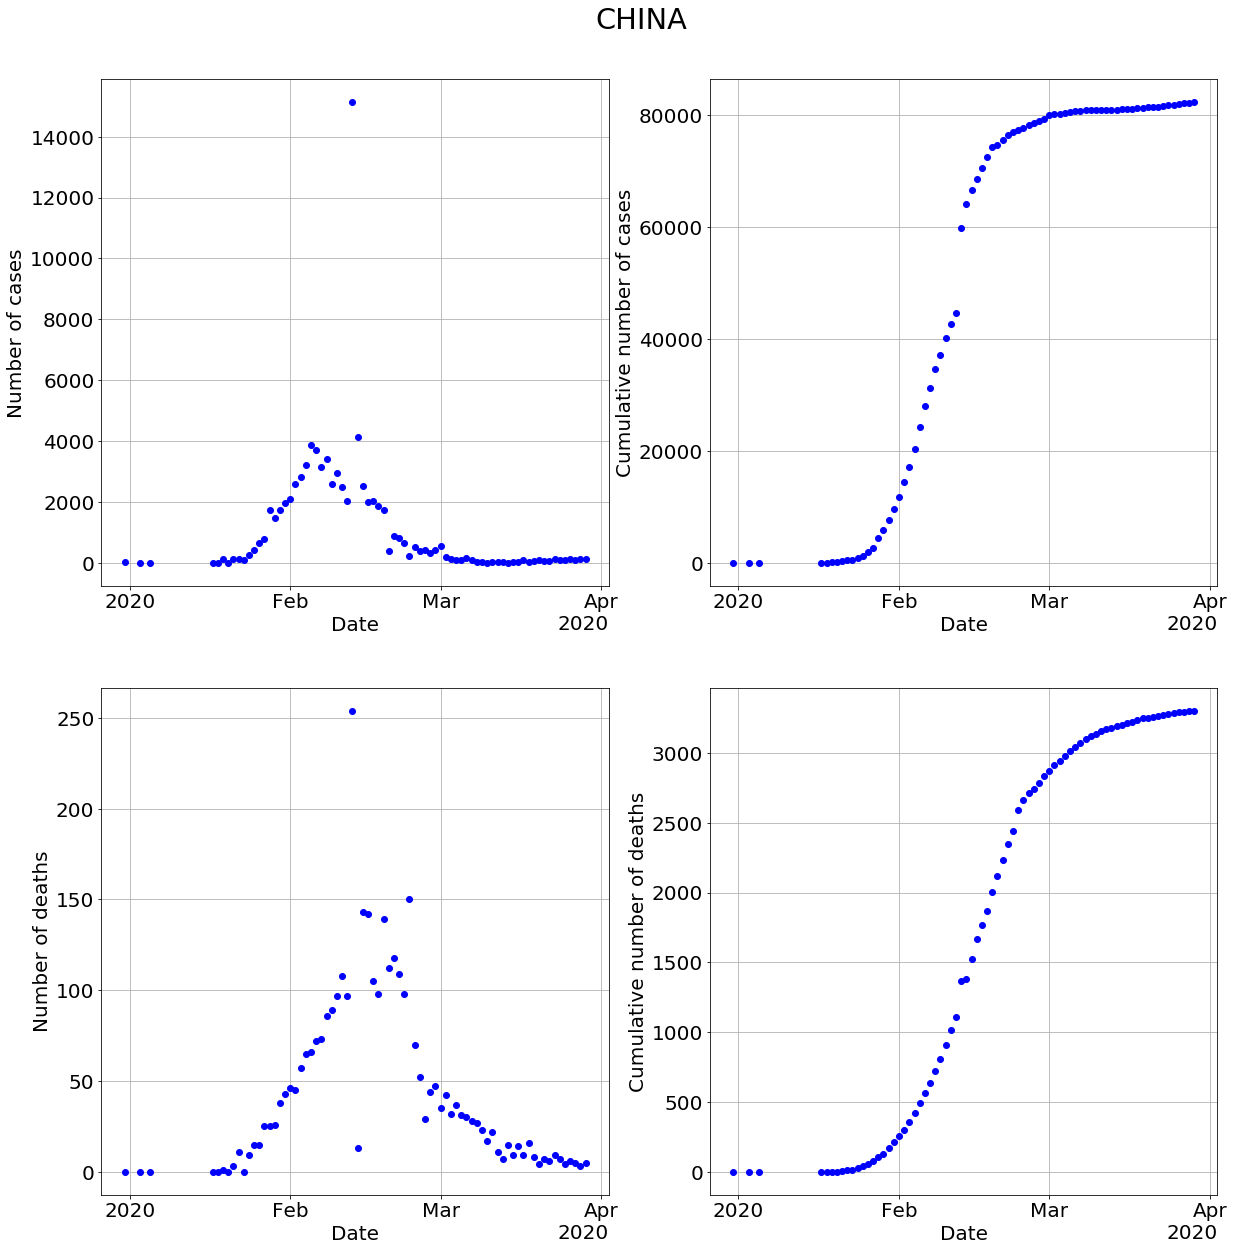

 Total cases   confirmed =82342
 Total deaths  confirmed =3304


In [341]:
cplt.plot_cases_and_deaths(dfcn, country= 'CHINA', figsize=(20,20), log=False)

In [335]:
underreporting_estimate, total_cases = sts.total_cases(dfcn, cCFRBaseline = 1.38) 
print(f' Country =CHINA')
print(f' under reporting = {underreporting_estimate:.2e}')
print(f' total cases = {total_cases:.2f}')

 Country =CHINA
 under reporting = 3.03e-01
 total cases = 272073.12


In [337]:
dfkr = cio.ecdc_select_country(df, country='KR', thr=2)
dfkr

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
6330,2020-03-29,29,3,2020,105,8,South_Korea,KR,KOR,51635256.0
6331,2020-03-28,28,3,2020,146,5,South_Korea,KR,KOR,51635256.0
6332,2020-03-27,27,3,2020,91,8,South_Korea,KR,KOR,51635256.0
6333,2020-03-26,26,3,2020,104,5,South_Korea,KR,KOR,51635256.0
6334,2020-03-25,25,3,2020,100,6,South_Korea,KR,KOR,51635256.0
6335,2020-03-24,24,3,2020,76,7,South_Korea,KR,KOR,51635256.0
6336,2020-03-23,23,3,2020,64,9,South_Korea,KR,KOR,51635256.0
6337,2020-03-22,22,3,2020,98,1,South_Korea,KR,KOR,51635256.0
6338,2020-03-21,21,3,2020,147,3,South_Korea,KR,KOR,51635256.0
6339,2020-03-20,20,3,2020,87,9,South_Korea,KR,KOR,51635256.0


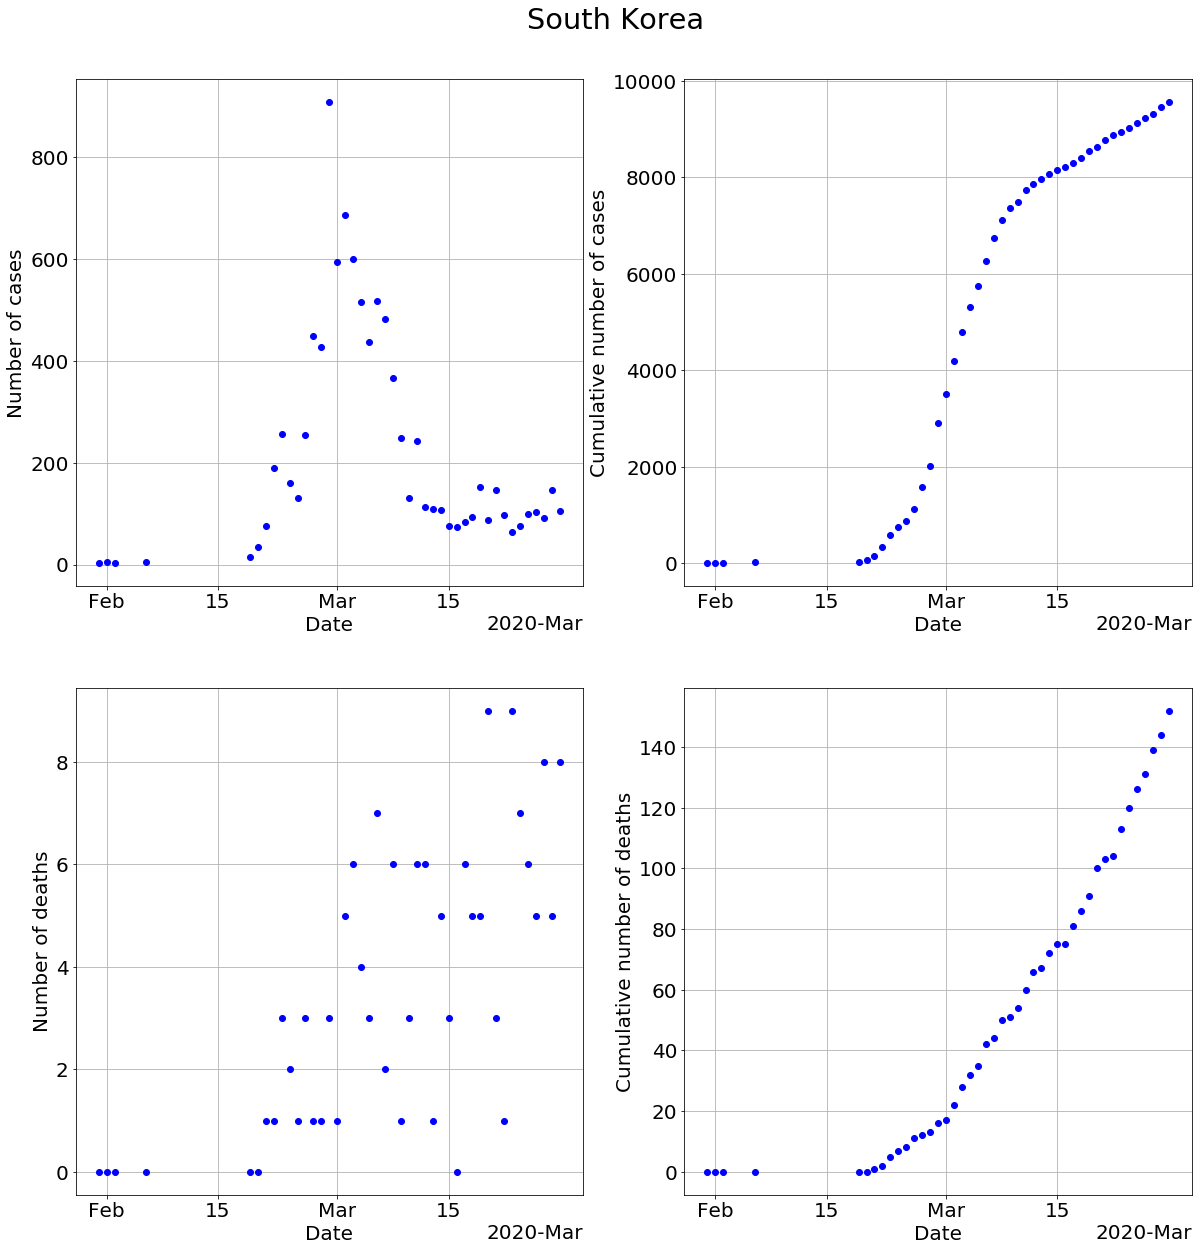

 Total cases   confirmed =9568
 Total deaths  confirmed =152


In [339]:
cplt.plot_cases_and_deaths(dfkr, country= 'South Korea', figsize=(20,20), log=False)

In [340]:
underreporting_estimate, total_cases = sts.total_cases(dfkr, cCFRBaseline = 1.38) 
print(f' Country =South Korea')
print(f' under reporting = {underreporting_estimate:.2e}')
print(f' total cases = {total_cases:.2f}')

 Country =South Korea
 under reporting = 6.62e-01
 total cases = 14446.42


In [ ]:
def plot_fits(df, country= 'Spain', figsize=(12,12), log=False):
    def formatter(ax):
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

    def cum_sum(df, data):
        Y = np.flip(df[data].values)
        CY = np.cumsum(Y)
        FCY = np.flip(CY)
        return FCY

    def formats(ax, xlabel, ylabel):
        formatter(ax)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if log:
            plt.yscale('log')

        plt.grid()


    fig = plt.figure(figsize=figsize)
    st = fig.suptitle(country, fontsize="x-large")

    X = df['dateRep'].values
    Y = df['cases'].values
    ax      = fig.add_subplot(2, 2, 1)
    plt.plot(X, Y, 'bo')
    formats(ax,'Date','Number of cases')


    ax      = fig.add_subplot(2, 2, 2)
    plt.plot(X, cum_sum(df, 'cases'), 'bo')
    formats(ax,'Date','Cumulative number of cases')

    Y = df['deaths']
    ax      = fig.add_subplot(2, 2, 3)
    plt.plot(X, Y, 'bo')
    formats(ax,'Date','Number of deaths')

    ax      = fig.add_subplot(2, 2, 4)
    plt.plot(X, cum_sum(df, 'deaths'), 'bo')
    formats(ax,'Date','Cumulative number of deaths')

    st.set_y(0.95)
    fig.subplots_adjust(top=0.90)

    #plt.tight_layout()
    plt.show()
    print(f' Total cases   confirmed ={df.cases.sum()}')
    print(f' Total deaths  confirmed ={df.deaths.sum()}')


In [32]:
def pltfit(C19, imin=5, imax=26, re=0.05, data='Cases', figsize=(12,12), linewidth=3, ms=7):
    def reverse(s):
        return s.sort_index(ascending=False)
 
    def geti(C19):
        return np.log(reverse(C19[data]).values[imin:imax])
    
    fig = plt.figure(figsize=figsize)
    
    I = geti(C19)  
    X = np.arange(len(I))
    
    pf = np.polyfit(X, I, 1)
    print(f'coefficients of poly fit: {pf}')
    ft = np.poly1d(pf)
    sigma = re  * I
    
    plt.errorbar(X, I, fmt="kp", yerr= re  * I, ms=ms, ls='none')
    plt.plot(X, ft(X), linewidth=linewidth)
    plt.xlabel('Date in days')
    plt.ylabel('Number of cases')
    plt.grid()
    return pf, get_chi2(I, ft(X), len(I), sigma)

    

coefficients of poly fit: [0.30649083 4.13645703]


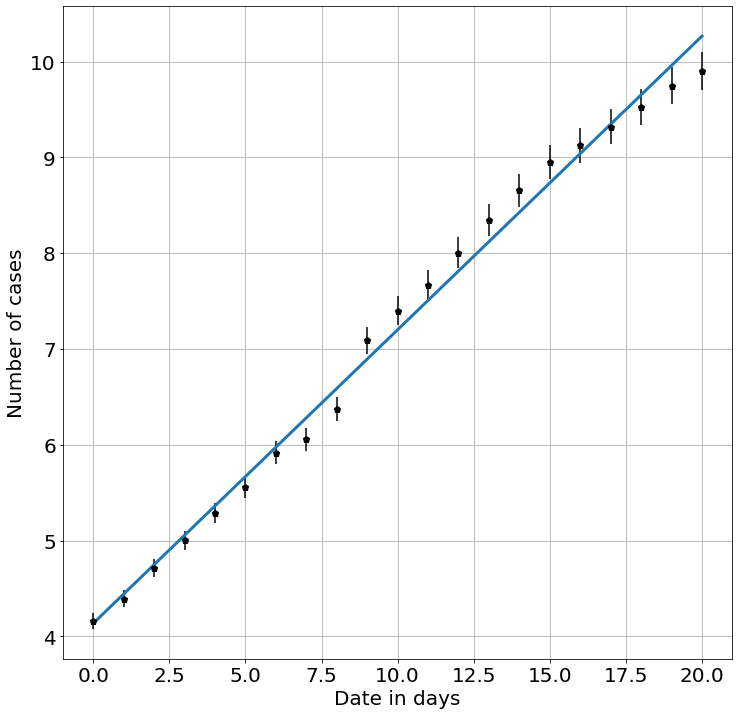

In [33]:
pf, chi2 = pltfit(c19s, imin=5, imax=26, re=0.02, data='Cases', figsize=(12,12), linewidth=3, ms=7)

In [36]:
print(f'duplication time = {1/pf[1]}')

duplication time = 0.24175278342482717


In [ ]:
za    = np.polyfit(fbib.W, fbib.I, 1)
print(f'coefficients of poly fit: {za}')

In [122]:
def expo_seed(x, y, eps=1e-12):
    """
    Estimate the seed for a exponential fit to the input data.
    """
    x, y  = zip(*sorted(zip(x, y)))
    const = y[0]
    slope = (x[-1] - x[0]) / np.log(y[-1] / (y[0] + eps))
    seed  = const, slope
    return seed

In [142]:
def fit_intensity(C19, data='C', ferr = 0.05, imax=3e+4, figsize=(10,10)):
    def reverse(s):
        return s.sort_index(ascending=False)

    y0 = reverse(C19.C).values
    print(y0)
    I = y0[25:50]
    print(I)
    X = np.arange(len(I))
    yerr= ferr  * I
    seed = expo_seed(X, I)
    f    = fitf.fit(fitf.expo, X, I, seed, sigma= yerr)
    fig = plt.figure(figsize=figsize)
    plt.errorbar(X,I, fmt="kp", yerr= yerr, ms=7, ls='none')
    plt.plot(X, f.fn(X), lw=3)
    
    #plt.ylim(0,imax)
    plt.xlabel('shot number')
    plt.ylabel('I (a.u.)')
    plt.show()
    print(f'Fit function -->{f}')
    return f.values, f.errors

[    1     1     1     1     1     1     1     1     1     2     2     2
     2     2     2     2     2     2     2     2     2     2     2     2
     3     7    12    25    34    66    83   114   151   200   261   374
   430   589  1204  1639  2140  3004  4231  5753  7753  9191 11178 13716
 17147 19980]
[    7    12    25    34    66    83   114   151   200   261   374   430
   589  1204  1639  2140  3004  4231  5753  7753  9191 11178 13716 17147
 19980]


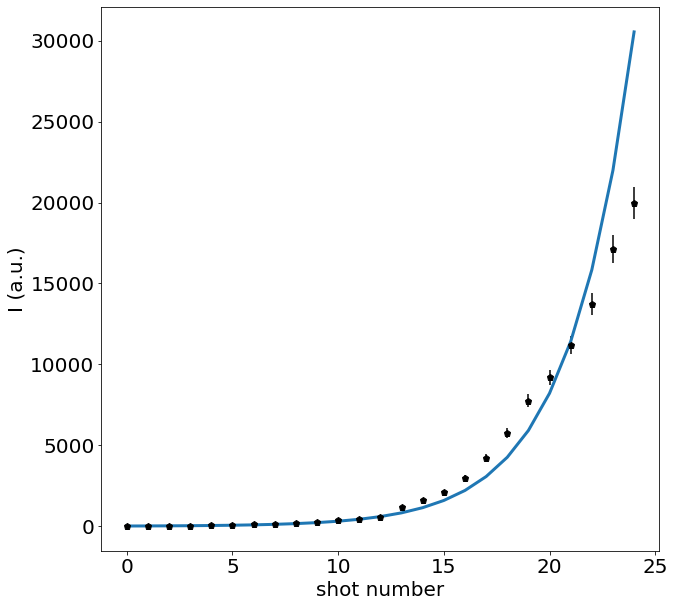

Fit function -->FitFunction(fn=<function fit.<locals>.<lambda> at 0x181c6f7b90>, values=array([11.55615939,  3.04580543]), errors=array([0.20626911, 0.01110921]), chi2=33.10034706076422, pvalue=5.202716091237219e-146, cov=array([[0.04254694, 0.00186194],
       [0.00186194, 0.00012341]]))


(array([11.55615939,  3.04580543]), array([0.20626911, 0.01110921]))

In [143]:
fit_intensity(c19s)